In [1]:
%load_ext autoreload
%autoreload 2

# Checking drift on existing dataset

In [1]:
!ls ../system/controller/reachability_estimator/data/trajectories/

linear_sunburst.trajectories.hd5.part  trajectories.hd5.old
trajectories.hd5		       trajectories.hd5.part


In [19]:
from system.controller.reachability_estimator.data_generation.gen_trajectories import display_trajectories

number of datasets:  432
000ed258
00141c38
0020c5e5
0036e5c3
00395bf5
0043e8ad
00625d5f
00647633
006ae341
006baea9
006ef539
007c6235
00911e03
00972190
0099aec3
00a47cff
00afffa3
00b3524b
00b94fec
00bf4bde
00d456fd
00f3b451
00f94362
010d3e78
011ac14f
0127c162
01346961
013926d4
01489821
0149cc86
014ea69d
01551e34
0157fc84
01775210
017c2df6
01865996
0187edf4
018f2428
0190e2ae
019a4022
01a887a5
01a928d8
01b2d695
01b9426c
01bbd7a8
01c1ac12
01ca655d
01dc6203
01e7b16a
01ed0380
01f30ba1
02013f8a
02066afd
02114a67
0217bf27
022b87a6
02331796
023b5f36
026abd54
026e5f62
027f1356
028f4535
029435f5
02987a22
029a8f33
02a2cae8
02a9fbe2
02ad7329
02d4a634
02d51dc9
02da11be
02e6685c
02eb7bff
02eb8687
02f70903
02fd83c8
03004631
03041d5f
0309271d
030cc0ac
0312e4c3
0314fec7
031a198a
031e4f9d
031f822b
032542e9
0325d955
0329f20e
032a9cf5
0338fea3
033f5a98
0344fa42
03495a9d
034fc57a
0355927c
035ab3d2
036541c0
036ae749
03779143
0377a636
0379b602
037f93bb
03872375
038bbf22
038be880
039329c0
03b411e7
03be245a
03c

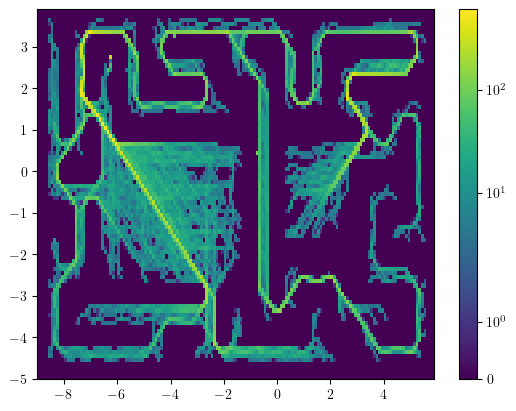

In [21]:
display_trajectories('../system/controller/reachability_estimator/data/trajectories/trajectories.hd5')

In [22]:
import h5py
f = h5py.File('../system/controller/reachability_estimator/data/trajectories/trajectories.hd5')
dset = next(iter(f.values()))
print(dset.dtype, len(dset))

[('xy_coordinates', '<f4', (2,)), ('orientation', '<f4'), ('grid_cell_spiking', '<f4', (9600,))] 302


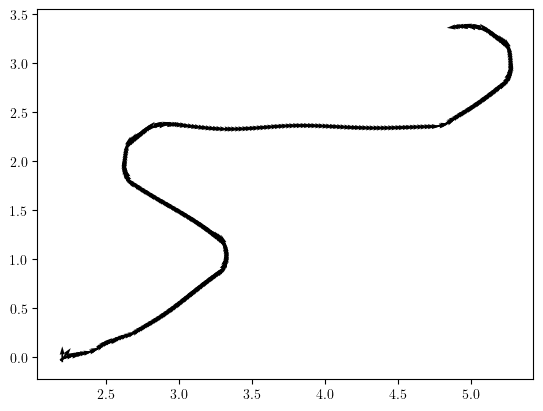

In [23]:
import numpy as np
import matplotlib.pyplot as plt

pos = dset['xy_coordinates']
x, y = pos[:, 0], pos[:, 1]
u, v = np.cos(dset['orientation']), np.sin(dset['orientation'])
plt.quiver(x, y, u, v)

In [24]:
from system.controller.local_controller.compass import AnalyticalCompass
from system.controller.local_controller.local_navigation import LinearLookaheadGcCompass, PodGcCompass, setup_gc_network
from tqdm import tqdm

gc_network = setup_gc_network(dt=1e-2)
ll_compass = LinearLookaheadGcCompass(arena_size=12, gc_network=gc_network)
pod_compass = PodGcCompass(gc_network=gc_network)
analytical_compass = AnalyticalCompass()

ll_compass.reset_position(np.reshape(dset[0]['grid_cell_spiking'], (6, 1600)))
analytical_compass.reset_position(dset[0]['xy_coordinates'])

def error(pos, spikings):
    ll_compass.reset_goal(spikings) # should also affect the PodGcCompass
    analytical_compass.reset_goal(pos)

    errors = []
    true_position = analytical_compass.calculate_goal_vector()
    for compass in (ll_compass, pod_compass):
        estimated_position = compass.calculate_goal_vector()
        error = estimated_position - true_position
        angle_error = np.arccos(np.dot(true_position, estimated_position) / np.linalg.norm(true_position) / np.linalg.norm(estimated_position))
        errors.append((error, angle_error))
    return errors

all_errors = (([], []), ([], []))
for point in tqdm(dset[1:]):
    spikings = point['grid_cell_spiking']
    spikings = np.reshape(spikings, (6, 1600))
    errors = error(point['xy_coordinates'], spikings)
    for topli, toppt in zip(all_errors, errors):
        for li, pt in zip(topli, toppt):
            li.append(pt)

/tmp/ipykernel_699800/39161769.py:5: DeprecatedWarning: setup_gc_network is deprecated
  gc_network = setup_gc_network(dt=1e-2)
  0%|                                                                                                                                                                                                   | 0/301 [00:00<?, ?it/s]/tmp/ipykernel_699800/39161769.py:22: RuntimeWarning: invalid value encountered in scalar divide
  angle_error = np.arccos(np.dot(true_position, estimated_position) / np.linalg.norm(true_position) / np.linalg.norm(estimated_position))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 301/301 [23:13<00:00,  4.63s/it]


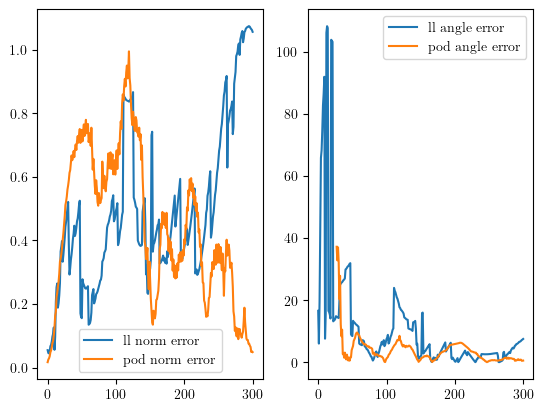

In [30]:
fig, axes = plt.subplots(1, 2)
axes[0].plot([np.linalg.norm(err) for err in all_errors[0][0]], label='ll norm error')
axes[0].plot([np.linalg.norm(err) for err in all_errors[1][0]], label='pod norm error')
axes[1].plot([np.degrees(err) for err in all_errors[0][1]], label='ll angle error')
axes[1].plot([np.degrees(err) for err in all_errors[1][1]], label='pod angle error')
for ax in axes: ax.legend()

In [31]:
xy = dset['xy_coordinates']
np.save('Savinov_val3.trajectory.npy', xy)

# Reproducing and investigating drift

In [2]:
from system.controller.local_controller.compass import AnalyticalCompass
from system.controller.local_controller.local_navigation import LinearLookaheadGcCompass, PodGcCompass, vector_navigation, create_gc_spiking
from system.bio_model.grid_cell_model import GridCellNetwork
import numpy as np

env_model = 'Savinov_val3'
path = np.load('./Savinov_val3.trajectory.npy')

from system.bio_model.cognitive_map import LifelongCognitiveMap
cogmap = LifelongCognitiveMap(reachability_estimator=None, load_data_from='cognitive_map_partial.gpickle', debug=False)
place_cells = list(cogmap.node_network.nodes.keys())
pc_network_start = place_cells[0].pos
"""
from system.bio_model.place_cell_model import PlaceCellNetwork
pc_network = PlaceCellNetwork(reach_estimator=None, from_data=True, map_name=env_model)
pc_network_start = pc_network.place_cells[0].pos
del pc_network
"""

read_gc_network = GridCellNetwork(from_data=True) # this points from the starting position to the current position.
# Its goal is reset to the goal position in the error() function, called every few steps
ll_compass = LinearLookaheadGcCompass(arena_size=12, gc_network=read_gc_network)
pod_compass = PodGcCompass(gc_network=read_gc_network)
analytical_compass = AnalyticalCompass()

def error(pos, spikings):
    ll_compass.reset_goal(spikings) # should also affect the PodGcCompass
    analytical_compass.reset_goal(pos)

    errors = []
    true_position = analytical_compass.calculate_goal_vector()
    for compass in (ll_compass, pod_compass):
        estimated_position = compass.calculate_goal_vector()
        error = estimated_position - true_position
        angle_error = np.arccos(np.dot(true_position, estimated_position) / np.linalg.norm(true_position) / np.linalg.norm(estimated_position))
        errors.append((error, angle_error))
    return errors

analytical_compass.reset_position(path[0])
start_spikings = create_gc_spiking(start=pc_network_start, goal=path[0], gc_network_at_start=read_gc_network)
ll_compass.reset_position(start_spikings)
# also affects the PodGcCompass, since they're both using the same GC network

from system.controller.reachability_estimator.reachability_estimation import reachability_estimator_factory
from system.controller.simulation.pybullet_environment import PybulletEnvironment
from system.controller.local_controller.local_controller import LocalController, controller_rules

env = PybulletEnvironment(env_model, visualize=False, start=path[0], build_data_set=True, contains_robot=False)
#with PybulletEnvironment(env_model, dt=gc_network.dt, build_data_set=True, start=path[0], visualize=visualize) as env:

pybullet build time: Nov 28 2023 23:48:36


In [3]:
DISTANCE_THRESHOLD = 2.0
ANGLE_THRESHOLD = 0.2

from system.controller.simulation.pybullet_environment import Robot

gc_network = GridCellNetwork(from_data=True) # Gets continuously updated during navigation. Points from current position to next goal
gc_network.set_as_current_state(start_spikings)

# Adapted from waypoint_movement
controller = LocalController(
    on_reset_goal=[controller_rules.TurnToGoal()],
    transform_goal_vector=[], # not using ObstacleAvoidance because the waypoints are not in obstacles anyway
    hooks=[controller_rules.StuckDetector()],
)

robot = Robot(env, base_position=path[0]).__enter__()
waypoint_compass = AnalyticalCompass(start_pos=path[0])

for i, goal in enumerate(path):
    #print_debug(f"new waypoint with coordinates {goal}.", f'{i / len(goals) * 100} % completed.')

    waypoint_compass.reset_goal(goal)
    goal_reached, last_pc = vector_navigation(env, waypoint_compass, gc_network, step_limit=5000,
                plot_it=False, exploration_phase=True, controller=controller)
    assert goal_reached

    if i % 25 == 0:
        all_errors = error(env.robot.position, gc_network.consolidate_gc_spiking())
        print(i, ':', all_errors)
        if np.linalg.norm(all_errors[0][0]) > 0.8:
            break

/u/halle/bpi/home_at/thesis/bio-inspired-navigation/system/controller/simulation/pybullet_environment.py:786: RuntimeWarning: invalid value encountered in divide
  normed_goal_vector = np.array(goal_vector) / np.linalg.norm(np.array(goal_vector))
/tmp/ipykernel_2002843/1433532169.py:35: RuntimeWarning: invalid value encountered in arccos
  angle_error = np.arccos(np.dot(true_position, estimated_position) / np.linalg.norm(true_position) / np.linalg.norm(estimated_position))
/tmp/ipykernel_2002843/1433532169.py:35: RuntimeWarning: invalid value encountered in scalar divide
  angle_error = np.arccos(np.dot(true_position, estimated_position) / np.linalg.norm(true_position) / np.linalg.norm(estimated_position))


0 : [(array([ 0.  , -0.05]), nan), (array([0.  , 0.05]), nan)]
25 : [(array([-0.25234024, -0.12827929]), 0.25261301336368497), (array([-0.30234024, -0.17827929]), nan)]
50 : [(array([-0.08231644, -0.28171344]), 0.253923899115872), (array([-0.69595411, -0.43437368]), 0.24813599184284893)]
75 : [(array([-0.18174577, -0.06505329]), 0.05472307414549921), (array([-0.62979872, -0.56840411]), 0.04781073258708025)]
100 : [(array([-0.04048349,  0.09007279]), 0.04784428975834536), (array([-0.50792736, -0.77096922]), 0.006838802198897656)]
125 : [(array([ 0.19592   , -0.26582396]), 0.15855847954189412), (array([-0.25565189, -0.95293867]), 0.018529441453645545)]
150 : [(array([ 0.18207354, -0.500345  ]), 0.149432514893884), (array([-0.07910586, -1.1376459 ]), 0.13942786493585965)]
175 : [(array([-0.06772572, -0.60939386]), 0.08172224469874302), (array([-0.01814639, -0.92833078]), 0.1882011939435233)]
200 : [(array([-0.28400466, -0.61486754]), 0.04494643071935676), (array([ 0.02721396, -0.74111688]

[-9.95975020e-02  4.74255404e-05]


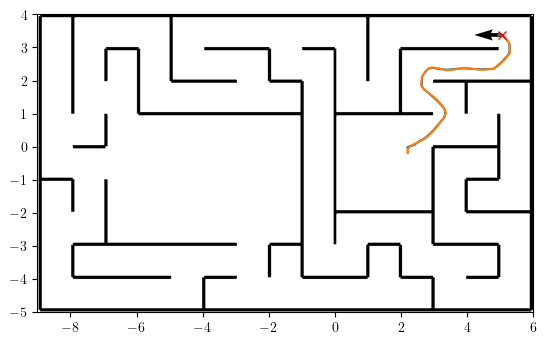

In [4]:
import matplotlib.pyplot as plt
from system.plotting.plotHelper import add_environment
fig, ax = plt.subplots()
add_environment(ax, env_model)
ax.plot([p[0] for p in path], [p[1] for p in path])
ax.plot([p[0] for p in robot.data_collector.xy_coordinates], [p[1] for p in robot.data_collector.xy_coordinates])
ax.plot(*env.robot.position, 'rx')
ax.quiver(*env.robot.position, *waypoint_compass.calculate_goal_vector())
print(waypoint_compass.calculate_goal_vector())

In [5]:
true_position = analytical_compass.calculate_goal_vector()
estimated_position = ll_compass.calculate_goal_vector()
pod_estimated_position = pod_compass.calculate_goal_vector()
true_position, estimated_position, pod_estimated_position

(array([2.86337466, 3.41640569]),
 array([2.4 , 2.85]),
 array([2.33260789, 3.07790348]))

In [6]:
assert pod_compass.gc_network is ll_compass.gc_network

In [7]:
current = pod_compass.gc_network.consolidate_gc_spiking()
goal = pod_compass.gc_network.target_spiking
current.shape, goal.shape

((6, 1600), (6, 1600))

In [8]:
from system.bio_model.place_cell_model import PlaceCellNetwork
#pc_network = PlaceCellNetwork(reach_estimator=None, from_data=True, map_name=env_model)
pc_network = PlaceCellNetwork(reach_estimator=None, from_data=False, map_name=env_model)
pc_network.place_cells = place_cells

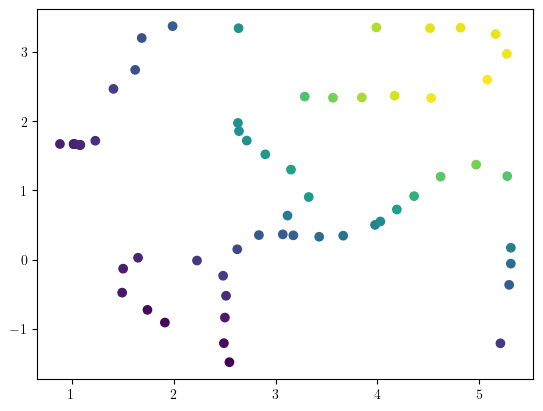

In [21]:
import matplotlib.pyplot as plt

pc_firing = pc_network.compute_firing_values(gc_network)
plt.scatter(x=[pc.pos[0] for pc in pc_network.place_cells], y=[pc.pos[1] for pc in pc_network.place_cells], c=pc_firing)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:04<00:00, 14.62it/s]


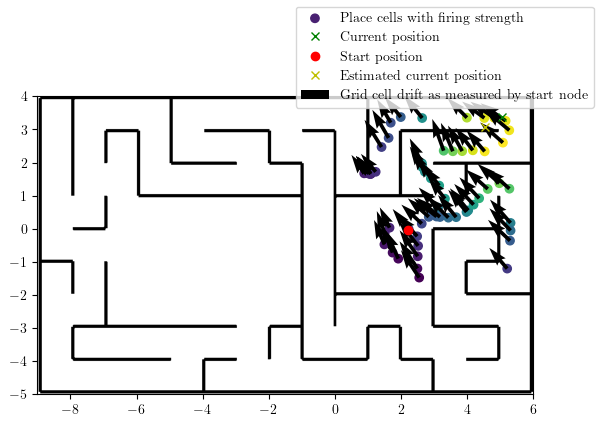

In [22]:
from system.plotting.plotHelper import add_environment
import numpy as np
from tqdm import tqdm
# experiment_offset is useful is we don't actually start the GC network at the first PC,
# but we want to map the results as though we had
# GC spikings in the PC network are relative to the 0 node,
# while in our experiment they are relative to path[0]
experiment_offset = np.array([0, 0]) #pc_network.place_cells[0].pos - path[0]

def plot_every_gc_error(from_pos, from_spikings):
    read_gc_network = GridCellNetwork(from_data=True)
    ll_compass = LinearLookaheadGcCompass(arena_size=12, gc_network=read_gc_network)
    pod_compass = PodGcCompass(gc_network=read_gc_network)
    analytical_compass = AnalyticalCompass()

    analytical_compass.reset_position(from_pos)
    ll_compass.reset_position(from_spikings)

    analytical_compass.reset_goal(env.robot.position)
    ll_compass.reset_goal(gc_network.consolidate_gc_spiking())

    fig, ax = plt.subplots()
    add_environment(ax, env_model)
    plt.scatter(x=[pc.pos[0] for pc in pc_network.place_cells], y=[pc.pos[1] for pc in pc_network.place_cells], c=pc_firing, label='Place cells with firing strength')
    plt.plot(*(env.robot.position + experiment_offset), 'gx', label='Current position')

    plt.plot(*(analytical_compass.current_pos + experiment_offset), 'ro', label='Start position')
    pod_estimated_position = pod_compass.calculate_goal_vector()
    plt.plot(*(analytical_compass.current_pos + pod_estimated_position + experiment_offset), 'yx', label='Estimated current position')

    # decode goal vectors from current position to every place cell on the cognitive map
    quivers = np.zeros((len(pc_network.place_cells), 4))
    for i, p in enumerate(tqdm(pc_network.place_cells)):
        pod_compass.reset_goal(p.spikings)
    
        pred_gv = pod_compass.calculate_goal_vector()
        true_gv = AnalyticalCompass(start_pos=pc_network.place_cells[0].pos, goal_pos=p.pos).calculate_goal_vector()
        error_gv = pred_gv - true_gv
        quivers[i, 0:2] = p.pos
        quivers[i, 2:4] = error_gv
    plt.quiver(quivers[:, 0], quivers[:, 1], quivers[:, 2], quivers[:, 3], label='Grid cell drift as measured by start node')
    
    fig.legend()

plot_every_gc_error(path[0], read_gc_network.consolidate_gc_spiking())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:03<00:00, 16.35it/s]


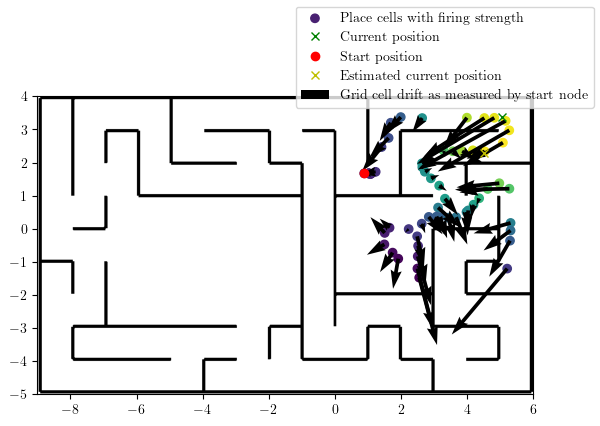

In [11]:
pc = pc_network.place_cells[0]
plot_every_gc_error(pc.pos, pc.spikings)

In [12]:
import numpy as np
prev_pos = None
for pc in pc_network.place_cells:
    if prev_pos is None:
        angle = 0
    else:
        dist = pc - prev_pos
        angle = np.angle(dist[0] + 1.0j*dist[1])
    pc.lidar = env.lidar((pc.pos, angle))[0]

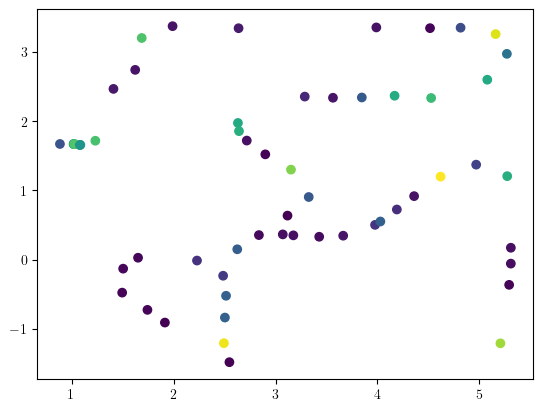

In [23]:
from system.controller.reachability_estimator.types import PlaceInfo
from system.controller.reachability_estimator.reachability_estimation import NetworkReachabilityEstimator
from system.controller.reachability_estimator.ReachabilityDataset import SampleConfig

config = SampleConfig(lidar='raw_lidar', grid_cell_spikings=False)
net_re = NetworkReachabilityEstimator.from_file('reachability_network' + config.suffix() + '+conv.25.050824.bak', config=config)

pos, angle = robot.position_and_angle
here = PlaceInfo(
    pos = pos,
    angle = angle,
    spikings = gc_network.consolidate_gc_spiking(),
    img = env.camera((pos, angle)),
    lidar = env.lidar((pos, angle))[0],
)
re_firing = [net_re.reachability_factor(pc, here) for pc in pc_network.place_cells]
plt.scatter(x=[pc.pos[0] for pc in pc_network.place_cells], y=[pc.pos[1] for pc in pc_network.place_cells], c=re_firing)

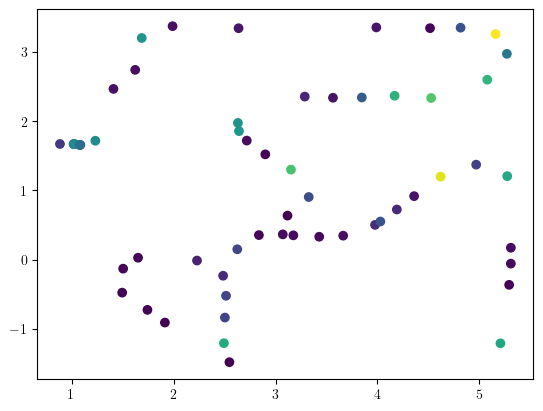

In [25]:
posterior_firing = np.array(pc_firing) * np.array(re_firing)
plt.scatter(x=[pc.pos[0] for pc in pc_network.place_cells], y=[pc.pos[1] for pc in pc_network.place_cells], c=posterior_firing)

In [19]:
dir(net_re.config)

['__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'image_crop',
 'images',
 'lidar',
 'suffix',
 'with_dist',
 'with_grid_cell_spikings']

In [40]:
help(PlaceInfo)

Help on class PlaceInfo in module system.controller.reachability_estimator.types:

class PlaceInfo(builtins.object)
 |  PlaceInfo(pos: system.types.Vector2D, angle: float, spikings: 'np.ndarray[float, (40, 40, 6)]', img: 'np.ndarray[float, (64, 64, 4)]', lidar: system.types.LidarReading) -> None
 |  
 |  All the info that can be extracted about a certain place.
 |  
 |  Methods defined here:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  __init__(self, pos: system.types.Vector2D, angle: float, spikings: 'np.ndarray[float, (40, 40, 6)]', img: 'np.ndarray[float, (64, 64, 4)]', lidar: system.types.LidarReading) -> None
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the 

In [52]:
robot.__exit__(None, None, None)

In [53]:
env.__exit__(None, None, None)